# Solution Overview

Our approach uses pretrained versatile language model embeddings to represent news articles:
1. We generate embeddings for all articles in the dataset, using a pretrained Large Language Model. 

    These sort of embeedings capture the semantic meaning of the whole text fragment and can be used in multilingual setting depending on the model.
    For the sake of fast prototyping, we decided to apply [OpenAI ADA Embeddings](https://platform.openai.com/docs/guides/embeddings), which are still considered state of the art across variety of NLP tasks according to results from 2023 paper [“MTEB: Massive text embedding benchmark”](https://arxiv.org/abs/2210.07316).

2. We generate embedding for each category name.

3. We calculate cosine similarity between each article and each category name. The category with the highest similarity is assigned to the article.


The solution so far achieves around 86% accuracy on the test set in the PoC phase.

Further work:
- We plan to try generating embeddings for category descriptions instead of category names. This has a chance to increase the precision of the categorization.
- We plan to use language models to generate a set of diversified descriptions for each category, based on the original description. Then we can generate their embeddings and approach the whole problem through as a sort of voting process. The are many ways to approach this so the details of such solutions are yet to be defined.



In [3]:
import sys
sys.path.append('../')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
from src.embedding_visualizer import EmbeddingVisualizer
from src.exploratory_data_analysis import Wordcloud, SentimentAnalyzer, gather_data
from textblob import TextBlob
import nltk
import seaborn as sns

The articles from STA dataset and IPTC taxonomy are loaded into the dataframes. The dataframe with articles already contains IPTC category labels, obtained via the bethod described above. 

For now, we focus only on the top hierarchy of IPTC taxonomy. The lower levels of this hierarchy are to be explored in the next stages of the project.

In [32]:
df = gather_data('../data/2023_articles_en')
df = df[df['text'].notna()]
df = df[['headline', 'keywords', 'categories', 'text', 'places', 'date', 'high_label', 'ada_embedding', 'high_label_similarity']]

taxonomy = pd.read_csv('../data/taxonomy/taxonomy.csv')

We check if every category from top level hierarchy appears in the predicted labels

In [6]:
assert len(taxonomy[taxonomy['hierarchy'] == 1]) == len(df['high_label'].unique())

Yes, it does.

## Prediction distribution

Now we perform the initial investigation of the predictions. 

One of the first and most important things to explore is the distribution of predictions, as our methodology of creating test set is heavily based on it.

In [7]:
df['high_label'].value_counts()

high_label
economy, business and finance      1757
politics                           1101
health                              899
weather                             815
crime, law and justice              759
sport                               633
arts, culture and entertainment     597
disaster and accident               583
labour                              527
environmental issue                 365
unrest, conflicts and war           352
education                           287
social issue                        221
science and technology              168
human interest                       90
lifestyle and leisure                76
religion and belief                  54
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of top-level hierarchy categories'}, xlabel='high_label'>

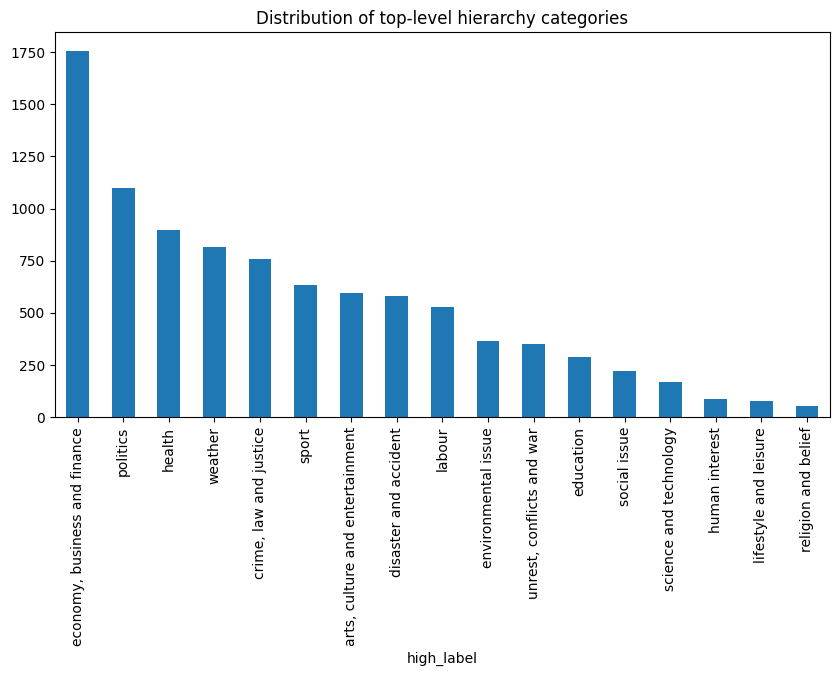

In [8]:
df['high_label'].value_counts().plot(kind='bar', figsize=(10, 5), title='Distribution of top-level hierarchy categories')


As we can see, the distribution is very imbalanced.

The next stage of investigation includes presenting visualizations, which help in understanding the model significance and its overall quality

## Most similar headlines for each IPTC category

We find embeddings of article headlines which are the closes the embeddings of IPTC category descriptions. We use cosine similarity to find the closest headlines.

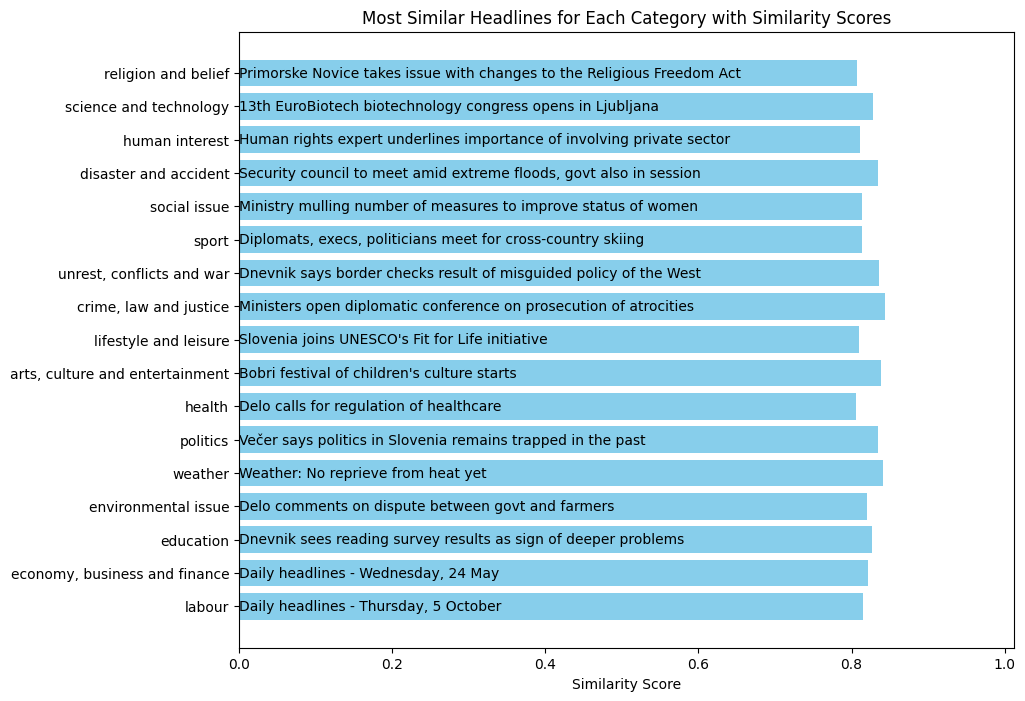

In [33]:
categories = []
similarity_scores = []
similar_headlines = []

for high_label in df['high_label'].unique():
    df_high_label = df[df['high_label'] == high_label]
    observation_with_highest_similarity = df_high_label.iloc[np.array(df_high_label['high_label_similarity']).argmax()]
    categories.append(high_label)
    similarity_scores.append(observation_with_highest_similarity['high_label_similarity'])
    similar_headlines.append(observation_with_highest_similarity['headline'])


# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(categories, similarity_scores, color='skyblue')

# Add labels directly on the bars
for bar, headline, score in zip(bars, similar_headlines, similarity_scores):
    ax.text(0, bar.get_y() + bar.get_height() / 2, headline, va='center', ha='left', color='black')

# Set x-axis limits
ax.set_xlim(0, 1.2 * max(similarity_scores))

plt.title("Most Similar Headlines for Each Category with Similarity Scores")
plt.xlabel("Similarity Score")
plt.show()


Initial result shows that the model based solely on embeddings might be promising. The headlines seem to match the categories quite well.

## Average word count per category

<Axes: title={'center': 'Average Word Count per Category'}, xlabel='high_label'>

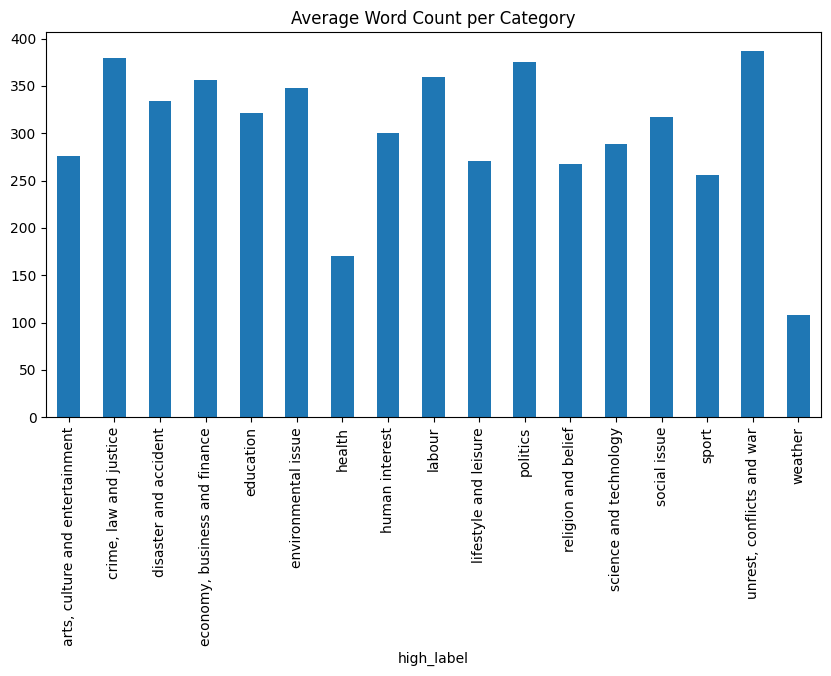

In [10]:
# word count in 'text' per 'high_label' category

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.groupby('high_label')['word_count'].mean().plot(kind='bar', figsize=(10, 5), title='Average Word Count per Category')

## Sentiment analysis - top 5 most negative article headlines and top 5 most positive article headlines

To increase our understanding of the data and get a better grip on it, we also performed sentiment analysis with the lexicon-based method (TextBlob). 

As we can notice, the average sentiment per category differs. According to intuition, the overall sentiment of articles is higher for the following categories: 
1. arts, culture and entertainment 
2. science and technology
3. sport 

While the lowest sentiment is predicted for news which touch hard and negative topics, such as: 
1. Law and justice
2. Unrest, conflicts and war

It is to be decided, whether to include the sentiment factor into the IPTC category modelling. One possible strategy would be to build model on top of the embeddings (or voting of different embeddings) which would take additional features for prediction, including such sentiment.

In [26]:
sentiment_analyzer = SentimentAnalyzer()
df['sentiment'] = df['text'].apply(sentiment_analyzer.get__textblob_sentiment)


[nltk_data] Downloading package punkt to /home/jan20/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


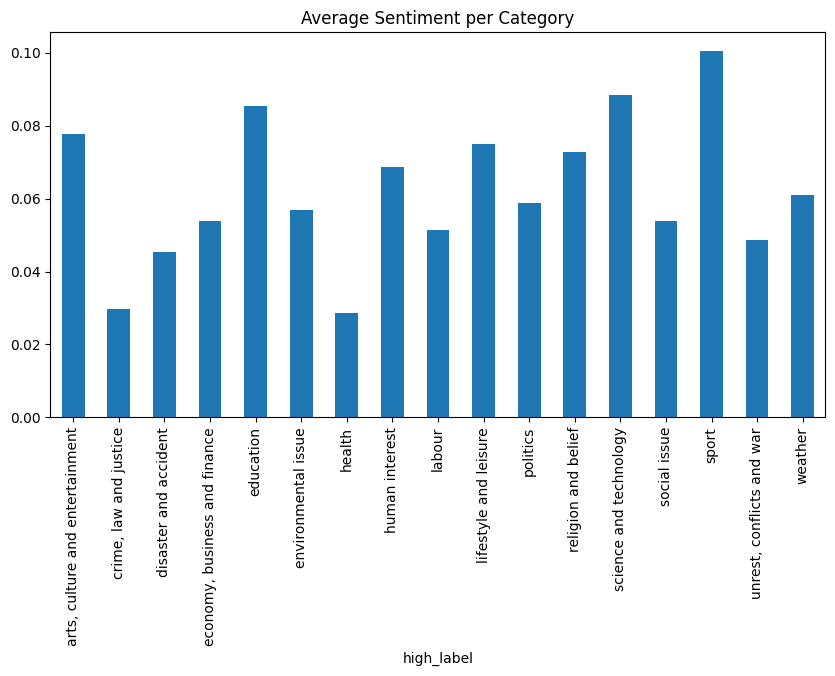

In [12]:
# plot sentiment per category
df.groupby('high_label')['sentiment'].mean().plot(kind='bar', figsize=(10, 5), title='Average Sentiment per Category')
plt.show()

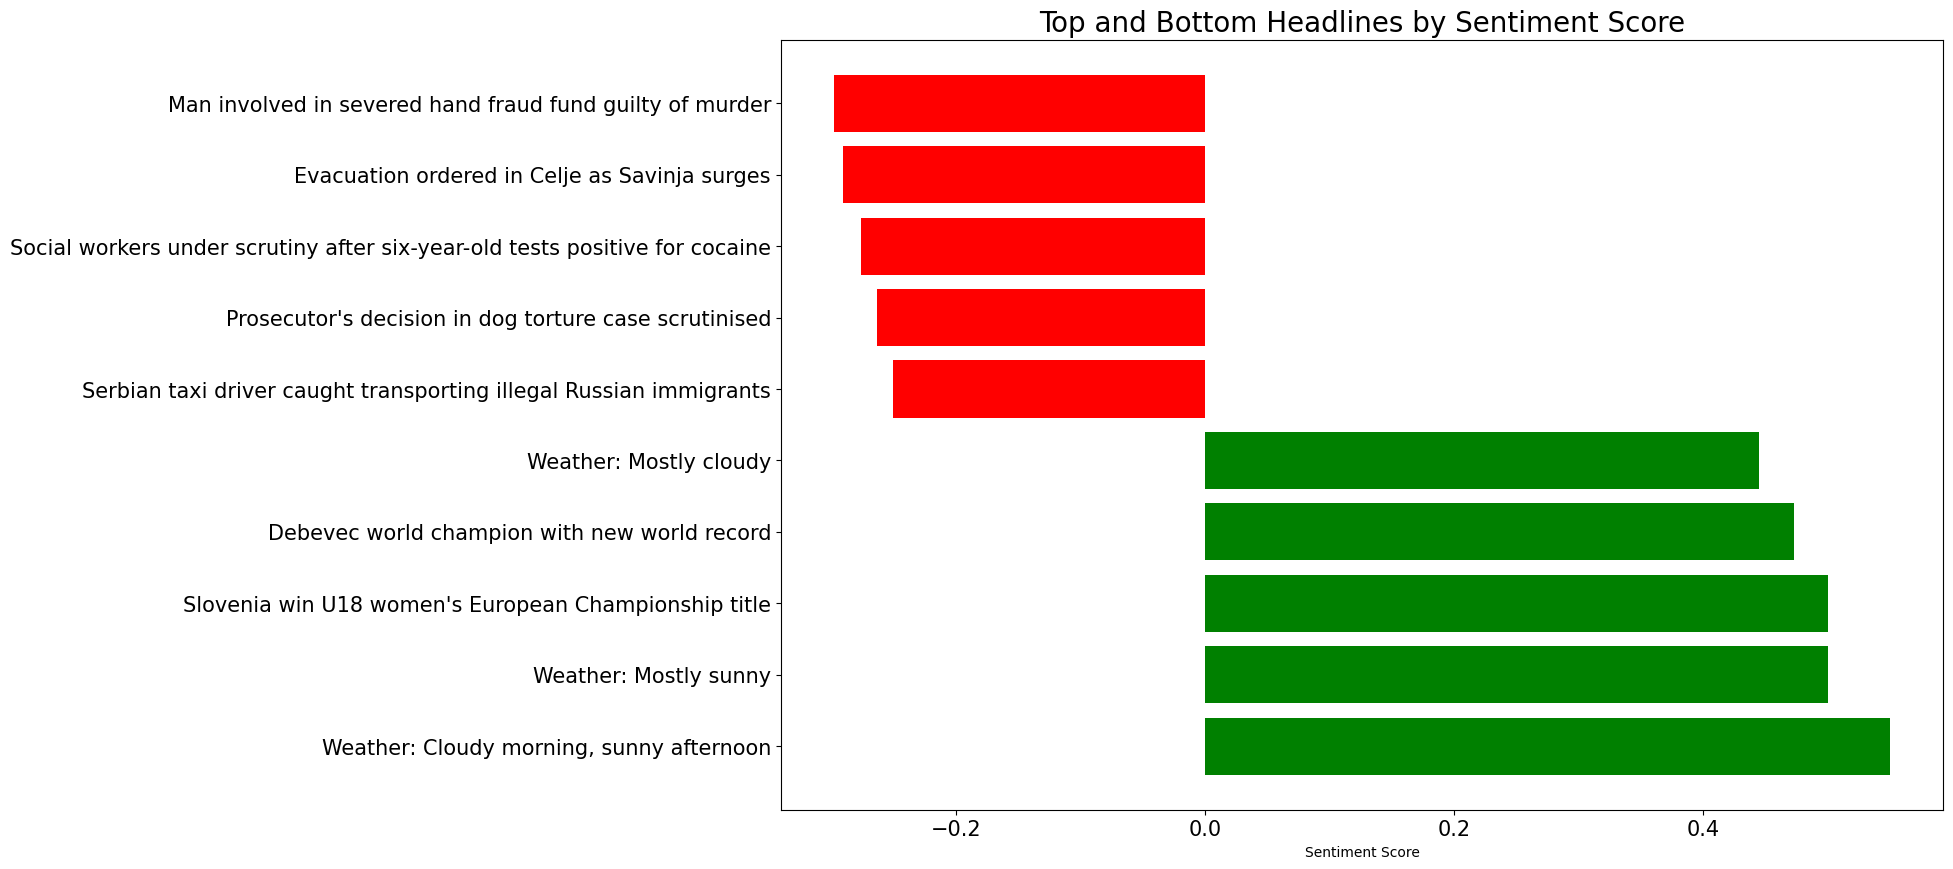

In [28]:
sorted_df = df[['sentiment', 'headline', 'text', 'high_label']].sort_values(by='sentiment', ascending=False)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'sorted_df' as described in your code

top_n = 5
bottom_n = 5

# Use concat to concatenate the head and tail DataFrames
unique_top_bottom_df = pd.concat([sorted_df.drop_duplicates(subset='headline').head(top_n),
                                  sorted_df.drop_duplicates(subset='headline').tail(bottom_n)])

plt.figure(figsize=(15, 10))
plt.barh(unique_top_bottom_df['headline'], unique_top_bottom_df['sentiment'], color=unique_top_bottom_df['sentiment'].apply(lambda x: 'green' if x > 0 else 'red'))
plt.xlabel('Sentiment Score')
plt.title('Top and Bottom Headlines by Sentiment Score', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()


In [14]:
df[['sentiment', 'headline', 'text', 'high_label']].sort_values(by='sentiment', ascending=False).head(10)

sentiment                                           headline  \
5043   0.550000           Weather: Cloudy morning, sunny afternoon   
4984   0.550000           Weather: Cloudy morning, sunny afternoon   
3016   0.500000                              Weather: Mostly sunny   
2887   0.500000  Slovenia win U18 women's European Championship...   
3745   0.500000                              Weather: Mostly sunny   
4054   0.500000                              Weather: Mostly sunny   
3652   0.500000                              Weather: Mostly sunny   
5155   0.483333                              Weather: Mostly sunny   
8201   0.472500       Debevec world champion with new world record   
545    0.444444                             Weather: Mostly cloudy   

                                                   text high_label  
5043  It will be mostly sunny and warm on Sunday and...    weather  
4984  It will be mostly sunny and warm on Sunday and...    weather  
3016  The outlook for the weekend is for mostly sunn...    weather  
2887  The Slovenian team cruised to the title by win...      sport  
3745  It should be mostly sunny in Tuesday and Wedne...    weather  
4054  It should be mostly sunny in Tuesday and Wedne...    weather  
3652  The outlook for the weekend is for mostly sunn...    weather  
5155  A strong north-easterly wind blow in most part...    weather  
8201  "In theory it is still possible to shoot bette...      sport  
545   The skies will be mostly cloudy on Thursday an...    weather

## Visualize top-level hierarchy IPTC categories with ADA embeddings



We also visualize the embeddings of category labels, to get better understanding of the dependencies between the vector representation of different classes.

The embeddings are projected into 3D and 2D space with Principal Component Analysis. 

In [16]:
taxonomy = pd.read_csv('../data/taxonomy/embeddings/taxonomy_openai_ada.csv')

In [17]:
embeddings = taxonomy[taxonomy['hierarchy'] == 1]['embedding_name'].apply(eval)
embeddings = np.array([np.array(x) for x in embeddings.values])
ev = EmbeddingVisualizer(embeddings, taxonomy[taxonomy['hierarchy'] == 1]['name'].values)

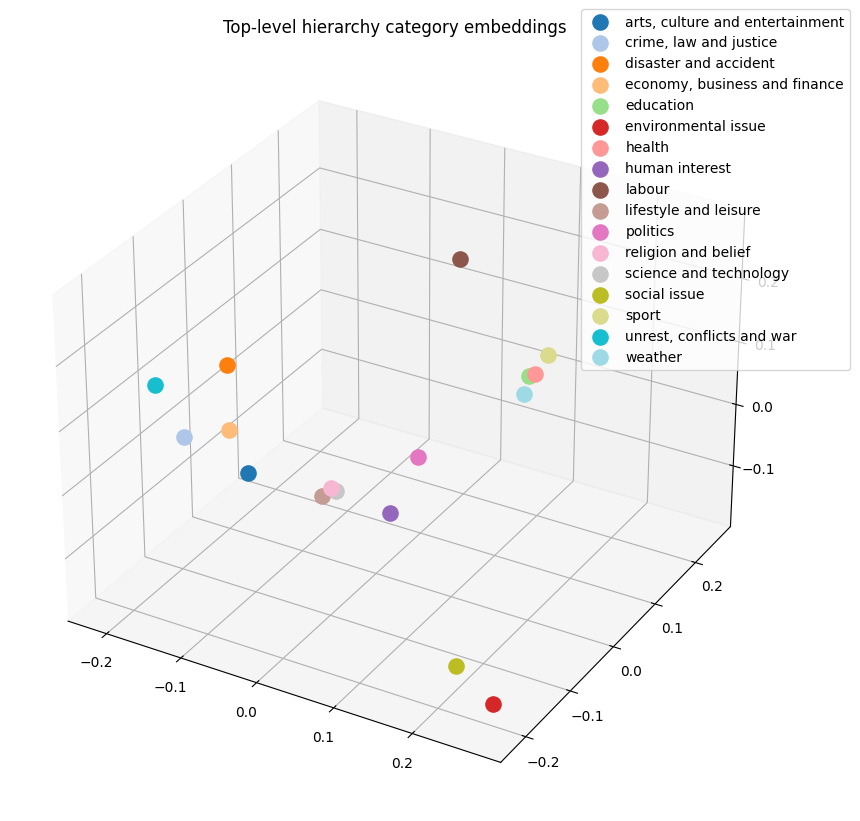

In [88]:
ev.visualize(dimension=3, method='pca', title='Top-level hierarchy category embeddings', s=120)

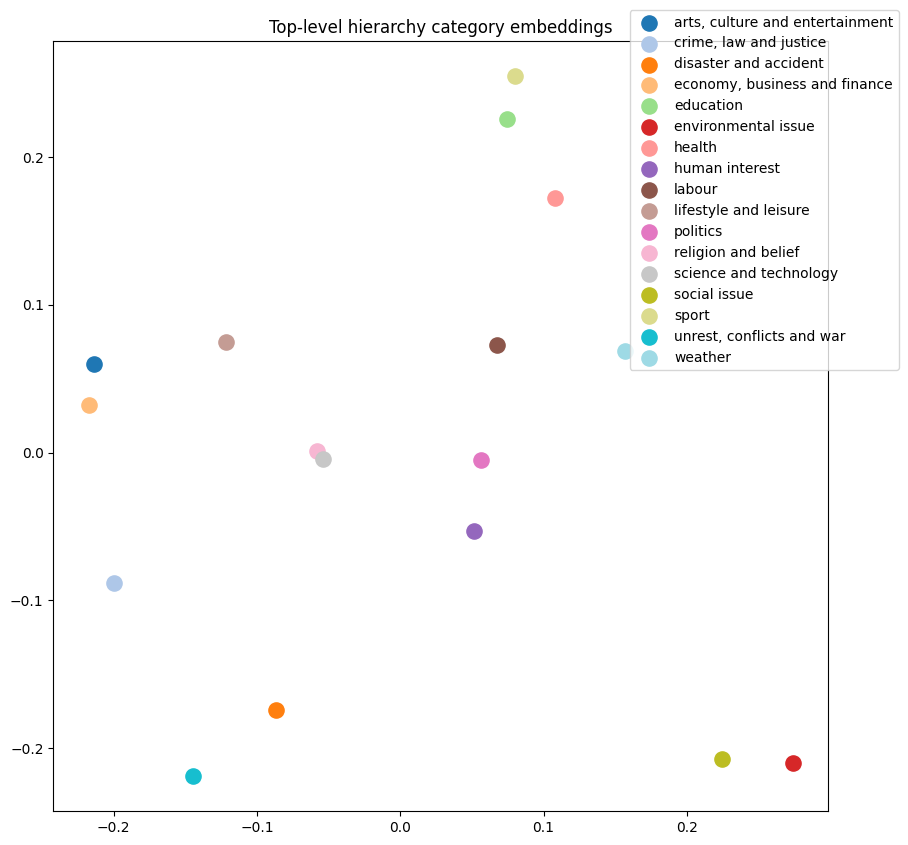

In [18]:
ev.visualize(dimension=2, method='pca', title='Top-level hierarchy category embeddings', s=120)

## Wordclouds for each predicted category

At last, wordclouds for each group of articles belonging to the same IPTC category are created. 

These visualizations confirm our beliefs that our proposed method works well, as the words appearing in these wordclouds are highly correlated to the names of IPTC categories.

Just giving an example, in SPORT wordcloud among the most common words we have team, won, point, tournament, race, e.t.c. 

While for ARTS, CULTURE AND ENTERTAINMENT we have festival, museum, artist, exhibition and others. 

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_wordcloud(df, title=None):
    all_text = ' '.join(df['text'])
    stopwords = set(STOPWORDS)
    stopwords.update(['a', 'i', 'u', 'e', 'o', 's', 't', 'm', 'd', 'n', 'r', 'l', 'c', 'p', 'g', 'h', 'b', 'f', 'k', 'w', 'v', 'y', 'j', 'z', 'x', 'q'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(all_text)

    # Create a subplot with more space between title and plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.subplots_adjust(top=10)  # Adjust this value to increase or decrease space

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=32)
    ax.axis('off')
    plt.show()

In [21]:
df['high_label']

0                              health
1                              labour
2       economy, business and finance
3                           education
4                 environmental issue
                    ...              
9279                            sport
9280           crime, law and justice
9281                           health
9282              environmental issue
9283                            sport
Name: high_label, Length: 9284, dtype: object

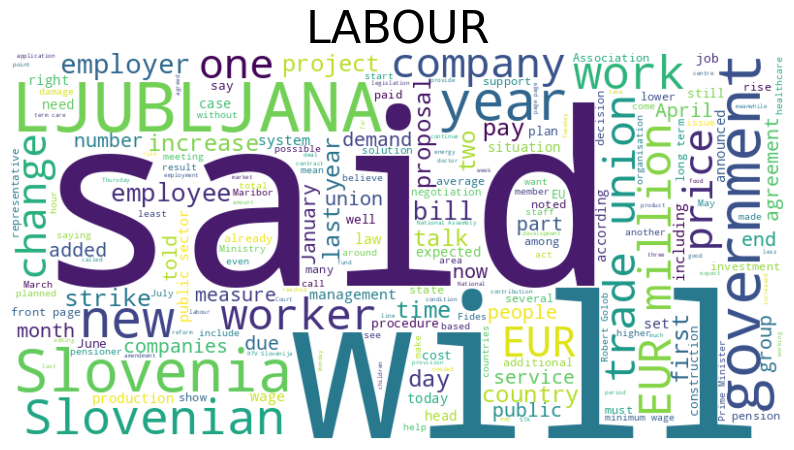

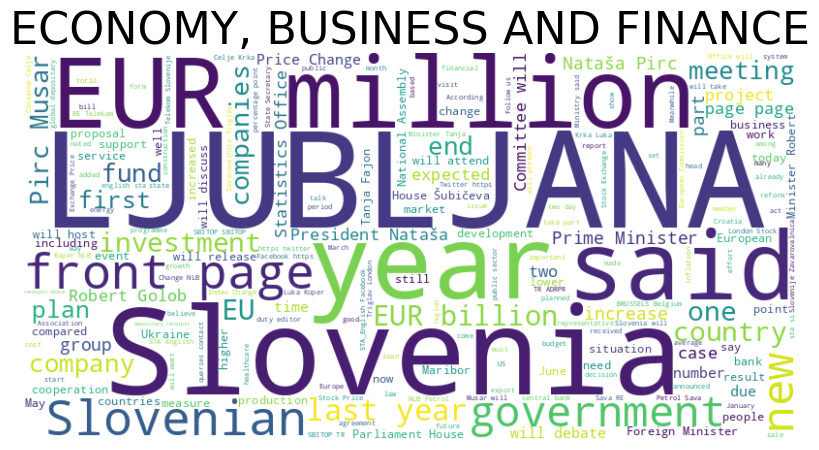

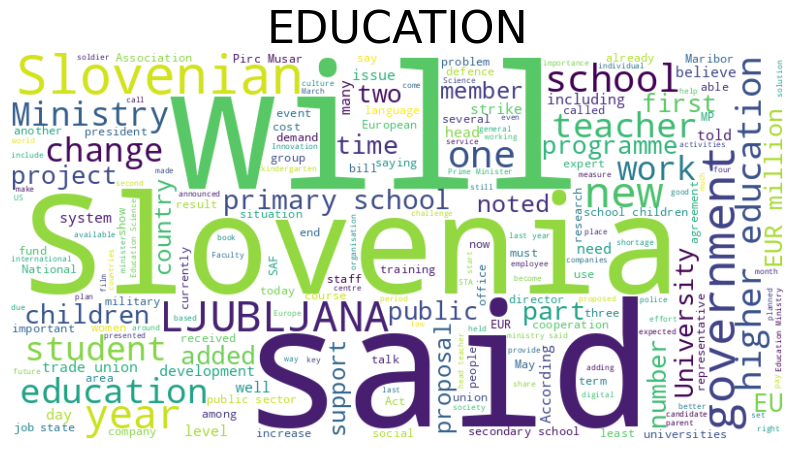

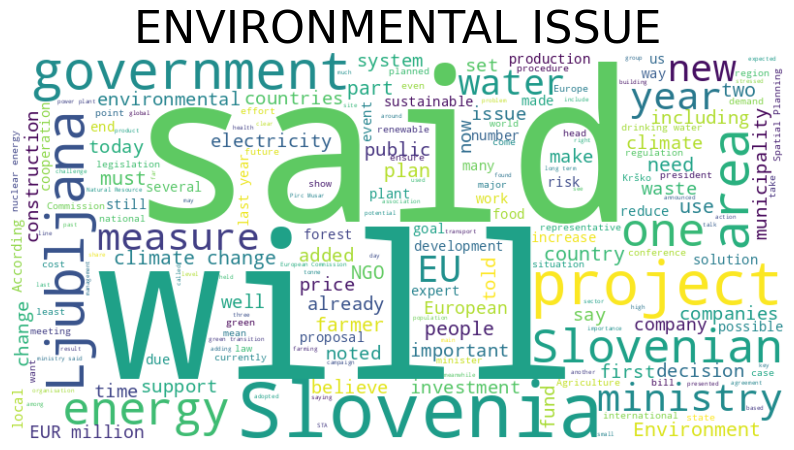

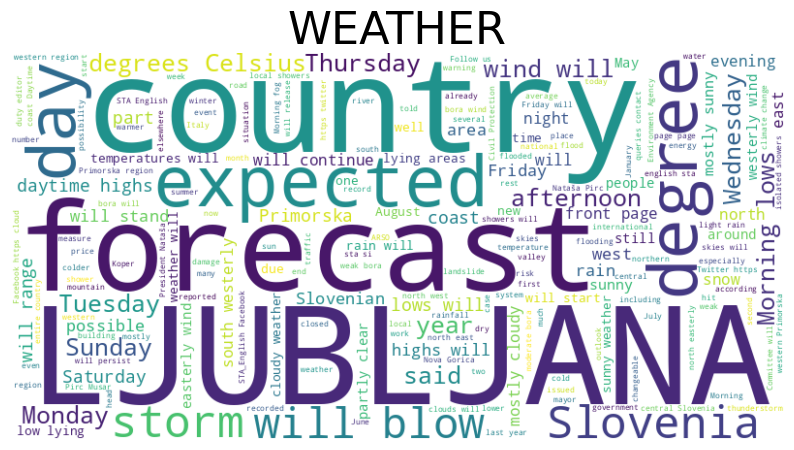

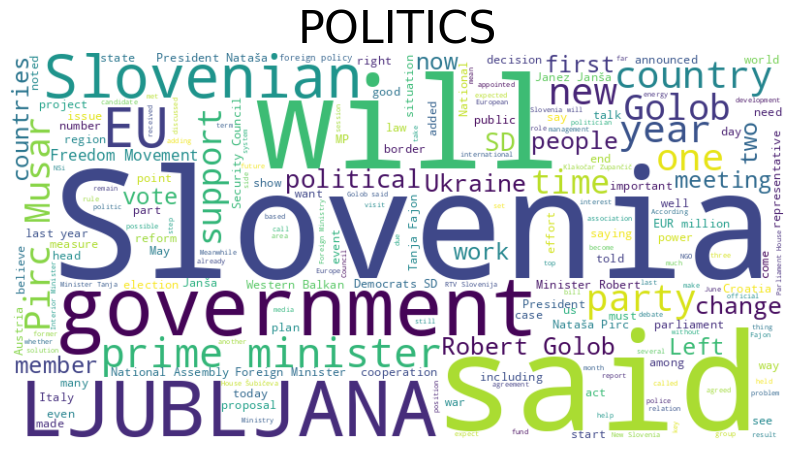

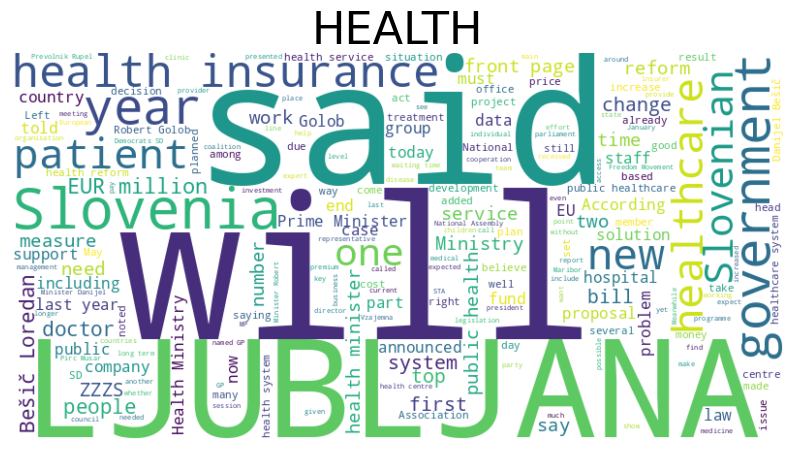

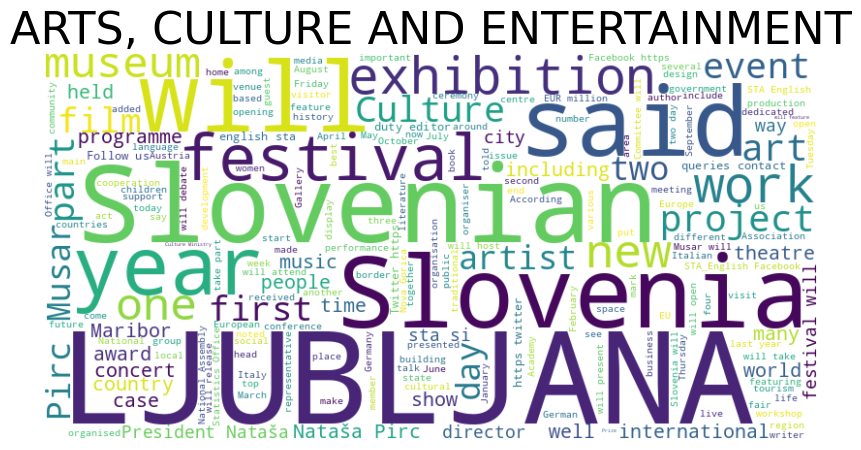

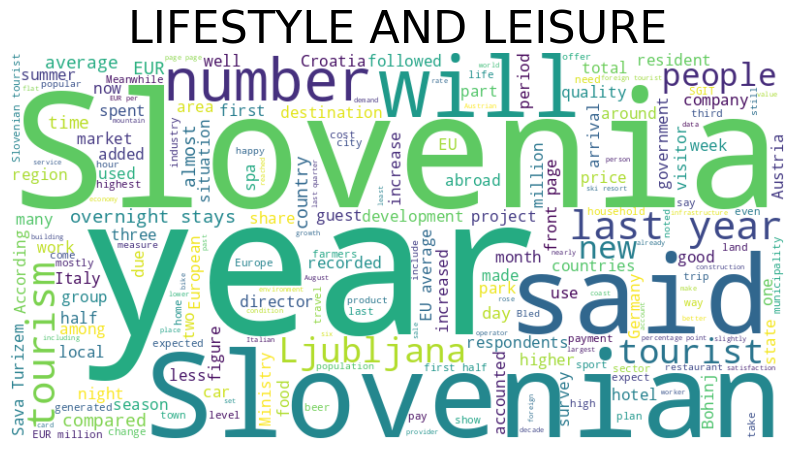

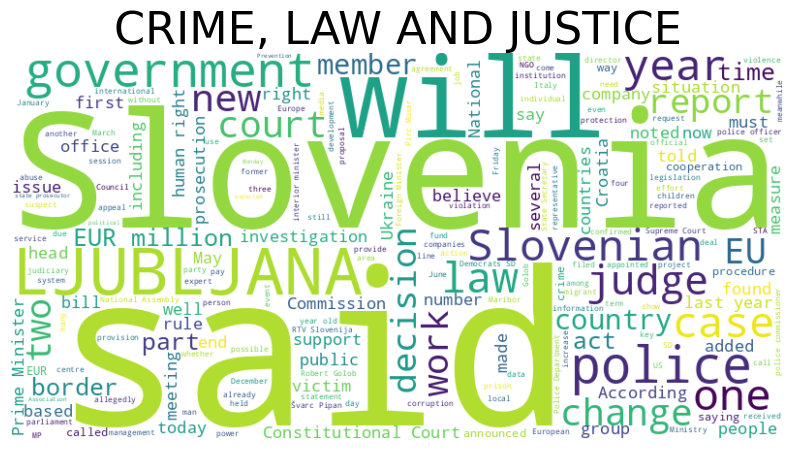

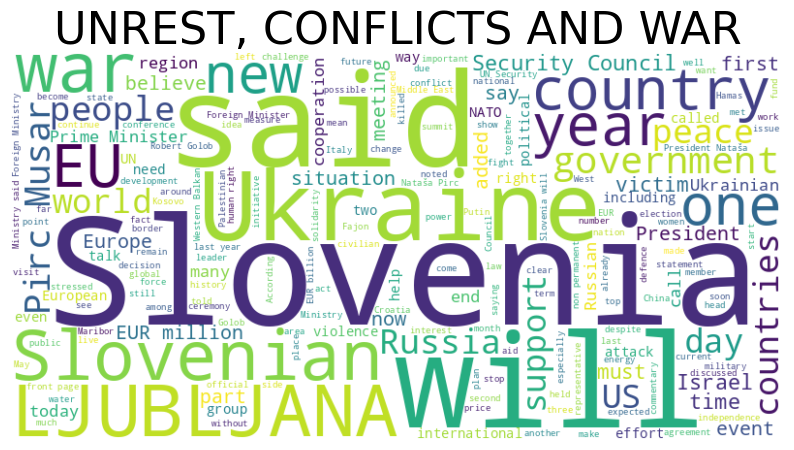

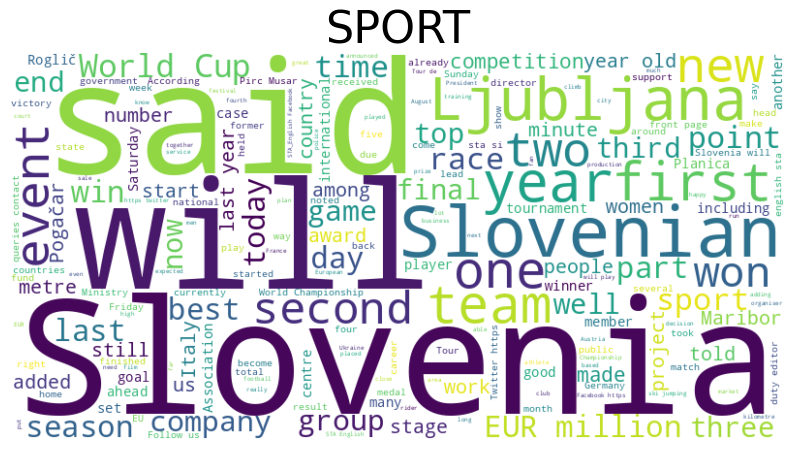

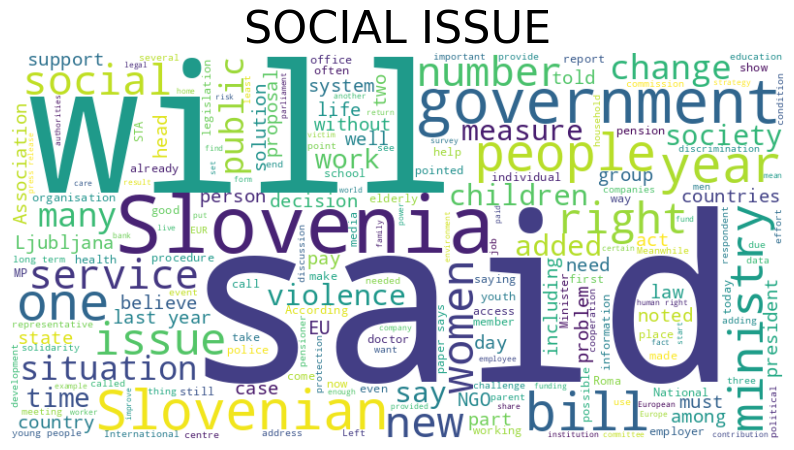

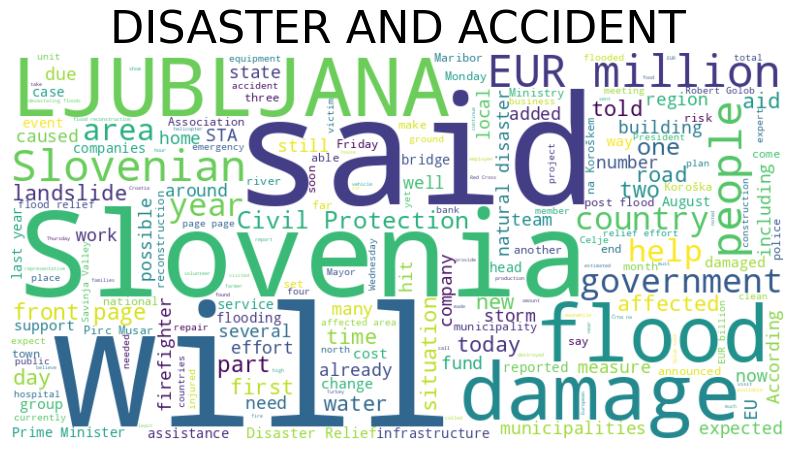

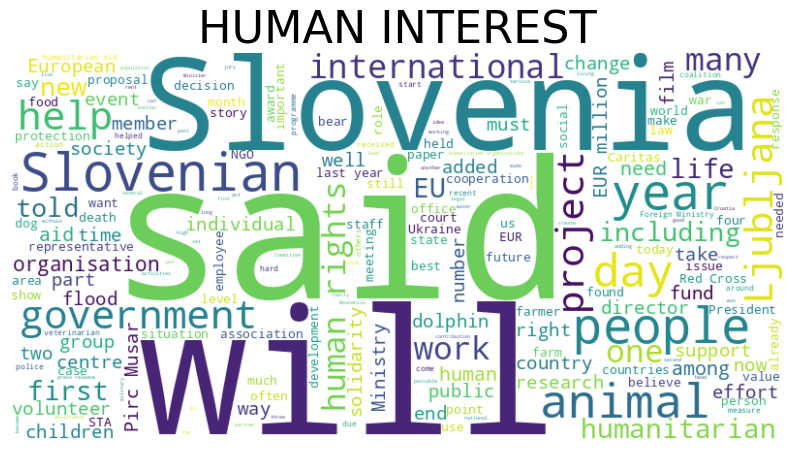

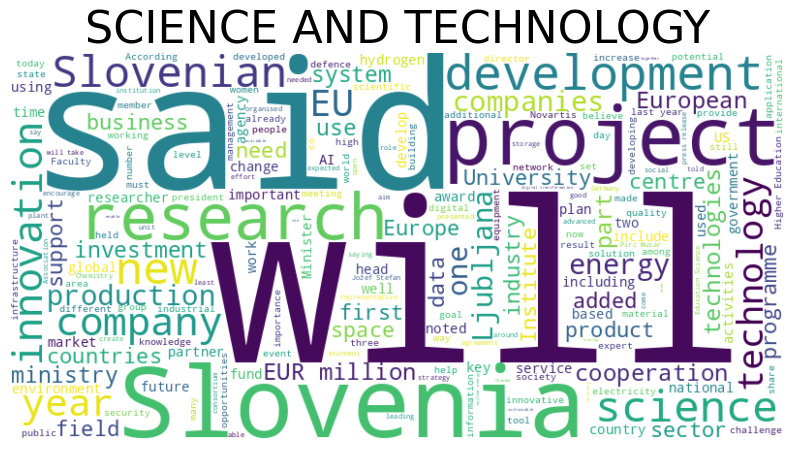

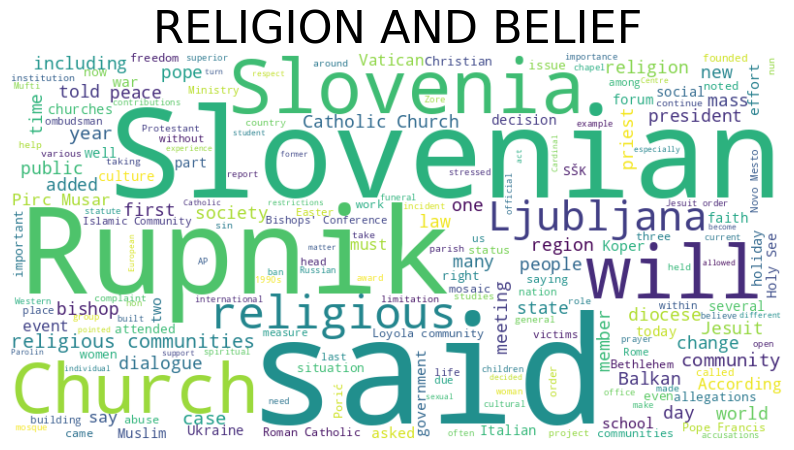

In [23]:
wordcloud = Wordcloud()
for label in df['high_label'].unique():
    text = ' '.join(df[df['high_label'] == label]['text'])
    wordcloud.plot_wordcloud(text, title= label.upper(), background_color='white', width=800, height=400)

## Creating confusion matrix based on labeled data and predictions

Accuracy: 0.8567
F1 Score: 0.8040


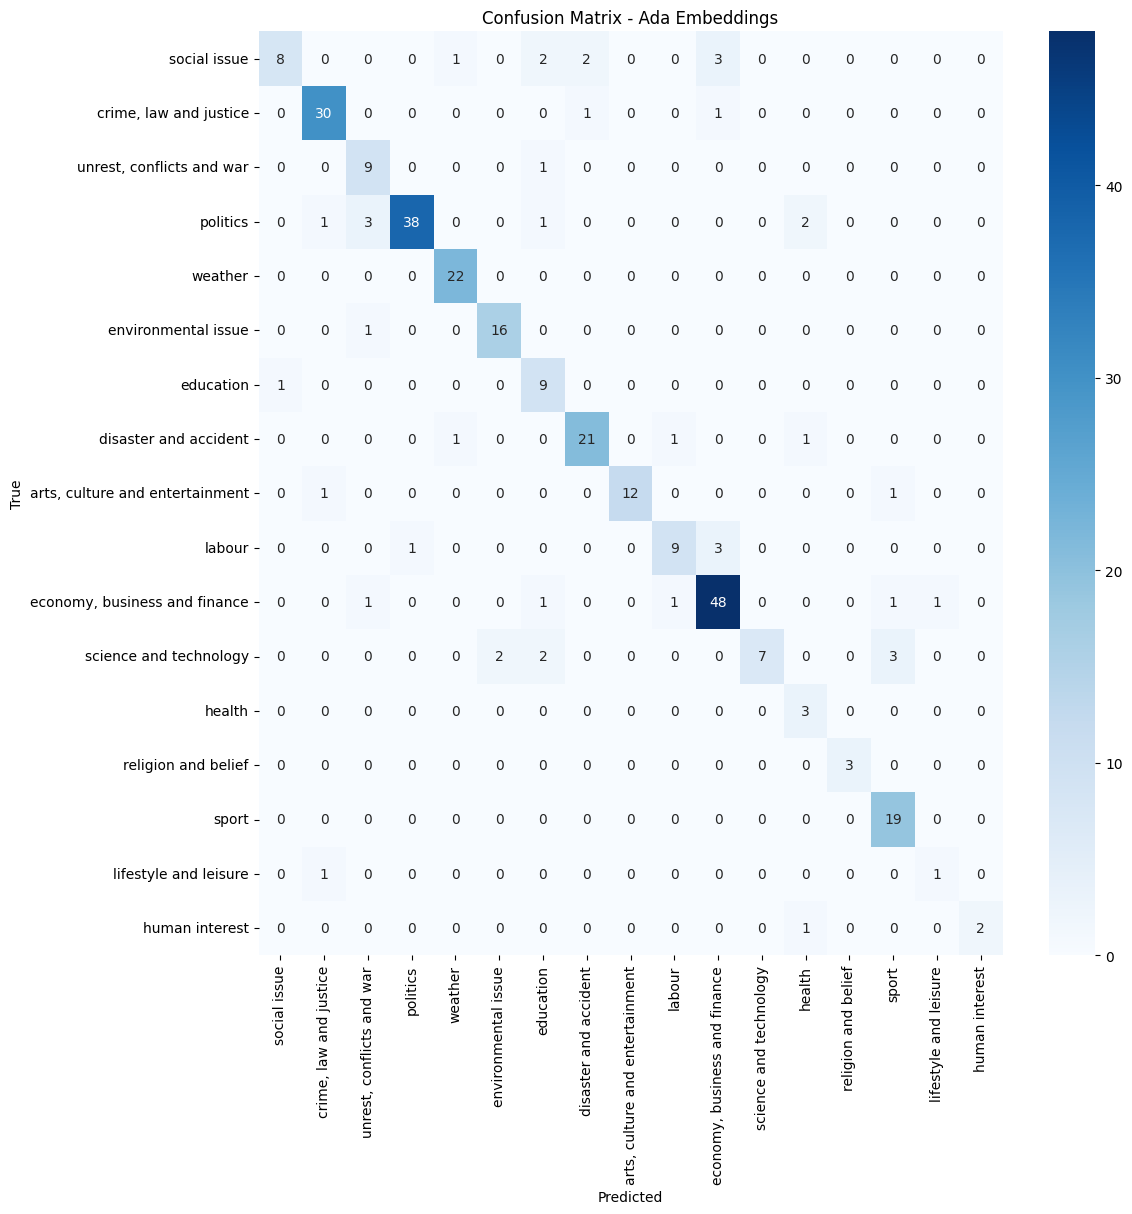

In [4]:
labeled_data=pd.read_csv('../labeling_app/labeled_data_old.csv')
label_mapping = {label: idx for idx, label in enumerate(labeled_data['high_label'].unique())}

labeled_data['proposed_label'] = labeled_data['proposed_label'].map(label_mapping)
labeled_data['high_label'] = labeled_data['high_label'].map(label_mapping)

true_labels = labeled_data['proposed_label']
predicted_labels = labeled_data['high_label']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1 Score: {f1:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
actual_labels = list(label_mapping.keys())
# Plot confusion matrix with actual labels on axes
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
plt.title('Confusion Matrix - Ada Embeddings')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



Accuracy: 0.6400
F1 Score: 0.5149


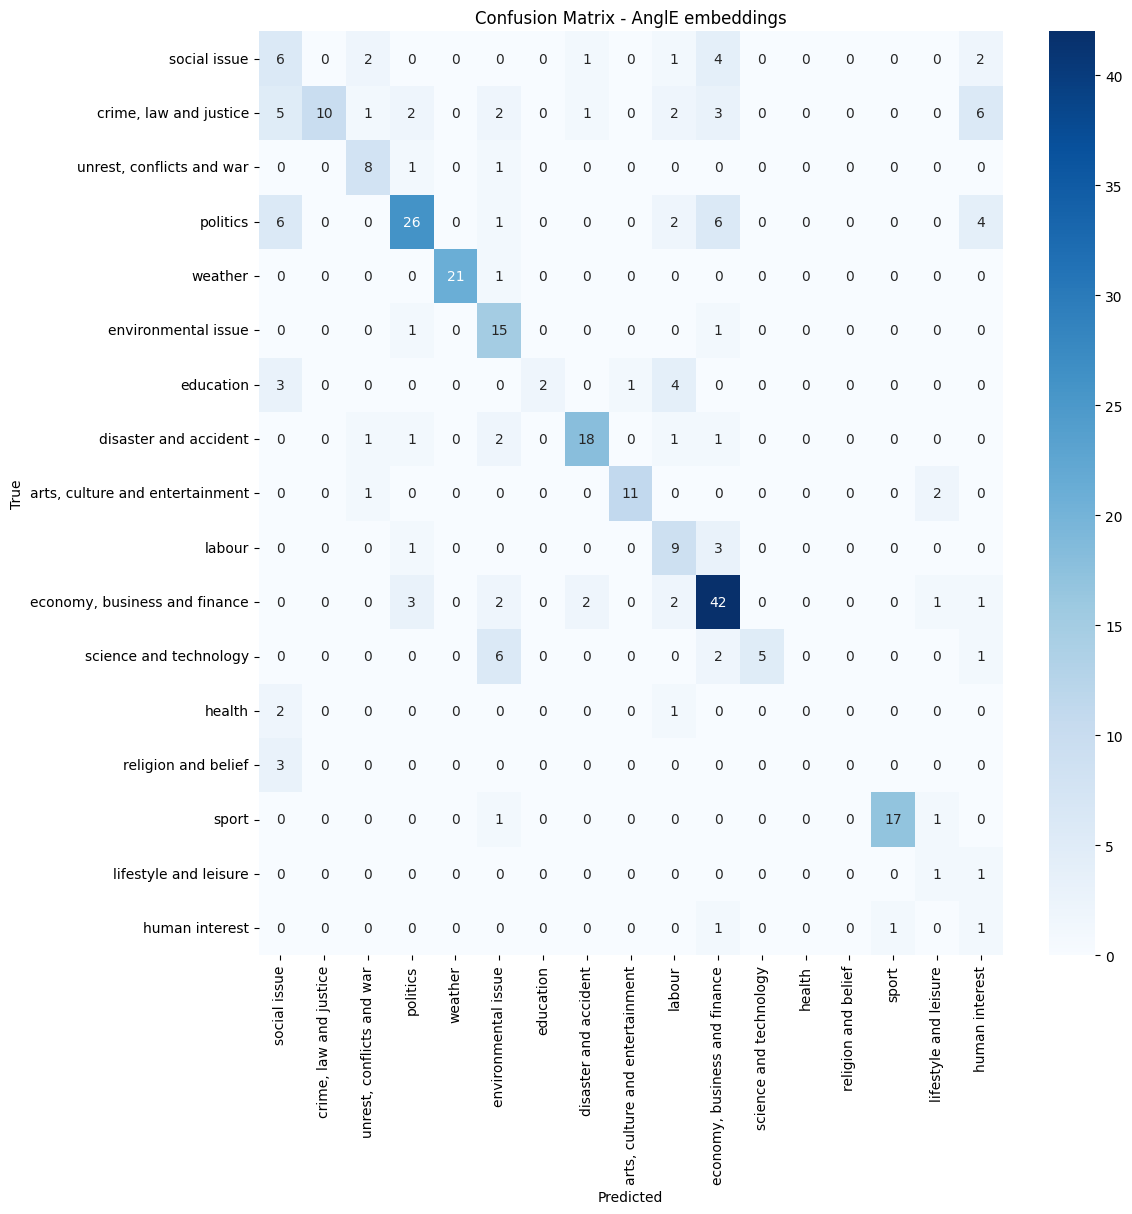

In [5]:
labeled_data=pd.read_csv('../labeling_app/labeled_data_old.csv')
label_mapping = {label: idx for idx, label in enumerate(labeled_data['high_label'].unique())}

labeled_data['proposed_label'] = labeled_data['proposed_label'].map(label_mapping)
labeled_data['high_label2'] = labeled_data['high_label2'].map(label_mapping)

true_labels = labeled_data['proposed_label']
predicted_labels = labeled_data['high_label2']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1 Score: {f1:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
actual_labels = list(label_mapping.keys())
# Plot confusion matrix with actual labels on axes
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
plt.title('Confusion Matrix - AnglE embeddings')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



We decided to use two metrics for evaluation of the model quality:
1. Accuracy (86%)
2. F1 - score (81.6%)

The results are promising and they represent the baseline for future improvement.

The confusion matrix shows, that the most troublesome articles do differentiate were coming from economy and politics classes. 

We believe, that the possible causes of such results are:
1. These classes are one of the most common ones in the test set and therefore the more observations might be prone to the misclassification
2. These classes seem to be related as they are often appear together in the news articles. Therefore it is a hard task to specify which IPTC class is more suitable.

The results also send an alarm that the single-class prediction might be insufficient and we might consider the multi-class approach in the upcoming stage of the project